# Model visualization

In [1]:
import numpy as np
import random as rnd
import pandas as pd

from python.model import Model
from python.parameters import CRITERION, MAXITERATIONS
from python.constants import BETA, R, IOTA, TAU, pp_range, o_range
from python.distributions import ZDISTRIBUTION, JOBDIST
from python.rouwen import rouwen

import matplotlib.pyplot as plt
%matplotlib inline

Parameters of simulation:

In [2]:
PERIODS = 30                               # Number of periods per one epoch
EPOCHS = 1                                 # Number of epochs  
AGENTS = 5000                              # Number of agents

Extended model class:

In [3]:
class NewModel(Model):
    def __init__(self):
        self.silent = False
        self.bond = [0.16, 0.15, 0.01]
        self.CRITERION = CRITERION
        self.MAXITERATIONS = MAXITERATIONS
        self.JOBS = 1
        
        self.BETA = BETA
        self.R =  R
        self.IOTA = IOTA
        self.TAU = TAU  # 0.73 #
        self.ZSHOCKS = 3
        self.pp_range = pp_range
        self.o_range = [False] #o_range
        self.PIMATRIX, self.z_shock_range = rouwen(0.64, 0, 0.07, 3)   
        self.ZDISTRIBUTION = ZDISTRIBUTION
        self.AUGMA = 22000
        self.AUGMH = 5600
        self.AMIN, self.AMAX, self.NBA = (10, 150000, 50)
        self.HMIN, self.HMAX, self.NBH = (100, 5600, 55)
        self.PSI = 0.45
        self.CHI = [0.03, 0.025]
        self.WAGECONSTANT = 7.27
        self.ALPHA = -0.19
        self.ZETA= [0, -0.11, -0.57, -0.28, -0.41, -0.55, -0.35, -0.63, -0.80]
        self.GAMMA = [0.42, 0.02, 0.03]
        self.XI = -0.04       
        self.updade_parameters()
        
    def wage(self, j, pp, h, h_cum, o, z_shock):
        '''
        Earnings function
        
        :param int j: current job type
        :param int pp: 1 = receiving PP, 0 = not receiving PP
        :param float h: current hours worked
        :param float h_cum: cumulative hours worked
        :param bool o: True = changed job, False = kept job
        :param float z_shock: shock
        '''
        if h == 0:
            return 0
        else:
            _log_h = np.log(h)
        if o:
            _o = 1
        else:
            _o = 0
        return np.exp(self.WAGECONSTANT + 
                    self.ALPHA*pp + 
                    self.ZETA[j] + 
                    self.GAMMA[0]*_log_h +
                    self.GAMMA[1]*np.log(h_cum) + 
                    self.GAMMA[2]*np.log(h_cum)*pp + 
                    self.XI*_o +
                    z_shock
                    )
    
    def utility(self, c, l, pp):
        '''
        Utility function on grid

        :param float c: consumption on grid
        :param float l: labor supply on grid
        '''
        _c = c / 65000
        return (_c**(1-self.IOTA))/(1-self.IOTA) - \
               self.CHI[pp]*(l**(1+self.PSI))/(1+self.PSI)
        
    def utility_matrix(self, index):
        (pp, j, o) = self.map_from_index(index)
        _temp_um = np.zeros((self._full_size, self._full_size, 
                                         self.ZSHOCKS), dtype=float)
        _temp_um.fill(np.nan) 
        for z_shock in range(self.ZSHOCKS): 
            for h_start in self.h_grid:
                for a_start in self.a_grid:
                    for h_end in self.h_grid:
                        if h_end < h_start or h_end - h_start > self.AUGMH:
                            continue
                        for a_end in self.a_grid:
#                             if a_start - a_end > self.AUGMA:
#                                 continue
                            _c = self.grid_consumption(j, pp, h_end, h_start, 
                                                 a_end, a_start, o, z_shock);
                            if _c <= 0:
                                continue
                            if h_start > self.HMAX - self.bond[0]*self.AUGMH:
                                _l = self.bond[1] + pp*self.bond[2]
                            else:
                                _l = self.grid_labor(h_end, h_start)
                            _idx_1 = self.map_from_grid(a_start, h_start)
                            _idx_2 = self.map_from_grid(a_end, h_end)
                            _temp_um[_idx_1, _idx_2, z_shock] = \
                                     self.utility(_c, _l, pp)
        if not self.silent:
            print("Matrix: {0:2d}; Utility matrix calculated.".format(index))
        return _temp_um
    
    def show_assets(self, i, j, k):
        plt.figure()
        fig = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
        plt.subplot(1, 2, 1)
        plt.plot( self.a_grid, self.a_grid )
        for idx in i:
            plt.plot( self.a_grid,
                  self.a_grid[self.dr[idx].
                  reshape(self.NBH, self.NBA, self.ZSHOCKS)[j, :, k] % self.NBA] )
        plt.ylabel("next period asset")
        plt.xlabel("asset")

        plt.subplot(1, 2, 2)
        for idx in i:
            plt.plot(self.a_grid, self.v[idx].
                reshape(self.NBH, self.NBA, self.ZSHOCKS)[j, :, k] )
        plt.ylabel("value function")
        plt.xlabel("asset")

        plt.show()

    def show_hours(self, i, j, k):
        plt.figure()
        fig = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
        plt.subplot(1, 2, 1)
        plt.plot( self.h_grid, self.h_grid )
        for idx in i:
            for kdx in k:
                plt.plot( self.h_grid,
                     self.h_grid[self.dr[idx].
                     reshape(self.NBH, self.NBA, self.ZSHOCKS)[:, j, kdx] // self.NBA] )
        plt.ylabel("next period cumulative hours worked")
        plt.xlabel("cumulative hours worked")

        plt.subplot(1, 2, 2)
        for idx in i:
            for kdx in k:
                plt.plot(self.h_grid, self.v[idx].
                    reshape(self.NBH, self.NBA, self.ZSHOCKS)[:, j, kdx] )
        plt.ylabel("value function")
        plt.xlabel("cumulative hours worked")

        plt.show()

Global functions for simulation:

In [4]:
def simulate_agent(m, init):
    _a, _h, pp, _chosen = init
    _dr_idx = m.map_from_grid(_a, _h)
    res = np.array( [(0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)]*PERIODS )
    for period in range(PERIODS):
        _temp_v = [0]*m.JOBS
        _temp_idx = [0]*m.JOBS
        _temp_shock = [0]*m.JOBS 
        _hired = False
        if _chosen == -1: # if the agent is unemployed 
            for j in range(m.JOBS):
                _employed_prob = rnd.random()
                if (_employed_prob < _tm[j, 4]):
                    _hired = True
                    _z_shock_prob = rnd.random()
                    _z_index = 0
                    _sum = m.ZDISTRIBUTION[_z_index]
                    while (_sum < _z_shock_prob):
                        _z_index += 1
                        _sum += m.ZDISTRIBUTION[_z_index]
                    _temp_idx[j] = m.dr[m.map_to_index(pp, j, False)].reshape(
                                m.NBA*m.NBH, m.ZSHOCKS)[_dr_idx, _z_index]
                    _temp_v[j] = m.v[m.map_to_index(pp, j, False)].reshape(
                             m.NBA*m.NBH, m.ZSHOCKS)[_temp_idx[j], _z_index]
                    _temp_shock[j] = m.z_shock_range[_z_index]
                else:
                    _temp_v[j] = -np.inf
            if _hired:
                _chosen = np.argmax(_temp_v)
                _dr_idx = _temp_idx[_chosen]
                _o, _z_shock = False, _temp_shock[_chosen]
                
        else: # if the agent is employed 
            _layoff_prob = rnd.random()
            if (_layoff_prob < _tm[_chosen, 2]):    
                _chosen = -1
            else:
                _hired = True
                _pp_prob = rnd.random() # updating PP status
                if pp == 1:
                    if (_pp_prob < _tm[_chosen, 0]):
                        pp = 0
                    else:
                        pp = 1
                else:
                    if (_pp_prob < _tm[_chosen, 1]):
                        pp = 1
                    else:
                        pp = 0
                if True: #(_layoff_prob < _tm[_chosen, 2] + _tm[_chosen, 3]): # taking a new job            
#                     for j in range(m.JOBS):
#                         _z_shock_prob = rnd.random()
#                         _z_index = 0
#                         _sum = m.ZDISTRIBUTION[_z_index]
#                         while (_sum < _z_shock_prob):
#                             _z_index += 1
#                             _sum += m.ZDISTRIBUTION[_z_index]
#                         if (j != _chosen):
#                             _temp_idx[j] = m.dr[m.map_to_index(pp, j, j != _chosen)].reshape(
#                                 m.NBA*m.NBH, m.ZSHOCKS)[_dr_idx, _z_index]
#                             _temp_v[j] = m.v[m.map_to_index(pp, j, j != _chosen)].reshape(
#                                 m.NBA*m.NBH, m.ZSHOCKS)[_temp_idx[j], _z_index]
#                             _temp_shock[j] = m.z_shock_range[_z_index]
#                         else:
#                             _temp_v[j] = -np.inf
#                     _chosen = np.argmax(_temp_v)
#                     _dr_idx = _temp_idx[_chosen]
#                     _o, _z_shock = True, _temp_shock[_chosen]
#                 else: # staying at current job
                    _z_shock_prob = rnd.random()
                    _z_index = 0
                    _sum = m.ZDISTRIBUTION[_z_index]
                    while (_sum < _z_shock_prob):
                        _z_index += 1
                        _sum += m.ZDISTRIBUTION[_z_index]
                    _dr_idx = m.dr[m.map_to_index(pp, _chosen, False)].reshape(
                                m.NBA*m.NBH, m.ZSHOCKS)[_dr_idx, _z_index]
                    _o, _z_shock = False, m.z_shock_range[_z_index]
        
        if _hired:
            _l =  m.grid_labor(m.h_grid[_dr_idx // m.NBA], _h)
            _w = m.wage(_chosen, pp, _l*m.AUGMH, _h, _o, _z_shock)
            _c = m.consumption(m.a_grid[_dr_idx % m.NBA], _a, _w)
        else:
            _l = 0
            _w = 0
            _c = m.consumption(_a, _a, _w)
            _z_shock = np.nan
        if _w == 0:
            _lw = 0
        else:
            _lw = np.log(_w)    
        _h = m.h_grid[_dr_idx // m.NBA]
        _a = m.a_grid[_dr_idx % m.NBA]
        
        res[period] = (period + 25, _chosen + 1, pp, np.log(_h), _l, _c, _lw, _z_shock, _a)
    return res

def print_res(result):
    print(" Age| Job| PP| Shock | log(h)|     a|    l|     c| log(w) ")
    for period in range(len(result)):   
        (_age, _j, _pp, _lh, _l, _c, _lw, _z, _a) = tuple(result[period])       
        print("{0: 4.0f}|{1: 4.0f}|{2: 3.0f}|{3: 7.3f}|{4: 7.2f}|{5: 6.0f}|{6: 3.2f}|{7: 6.0f}|{8: 7.2f}".
                        format(_age, _j, _pp, _z, _lh, _a, _l, _c, _lw) )

Model evaluation (uncomment for new model directly from the notebook):

In [59]:
_h = 500
_a = 1
m = NewModel()
m.NBH = 900
m.HMIN = _h
m.HMAX = m.HMIN + m.AUGMH*15.0
m.NBA = 4
m.AMIN = _a
m.AMAX = m.AMIN + 4
m.CHI = [0.7, 0.69]
m.PIMATRIX, m.z_shock_range = rouwen(0.6, 0, 0.1, 3)   
m.updade_parameters()

Uncomment if you want save results to file

In [60]:
m.evaluate_model()
m.save_to_csv(64)

Matrix:  0; Utility matrix calculated.
Matrix:  1; Utility matrix calculated.
Matrix:  0; Iteration: 14; Distance: 0
Matrix:  1; Iteration: 14; Distance: 0


Load model data for Group 1 from existing file

In [19]:
m.load_from_csv(64)

Assets policy (regime index, hours index, shock index):

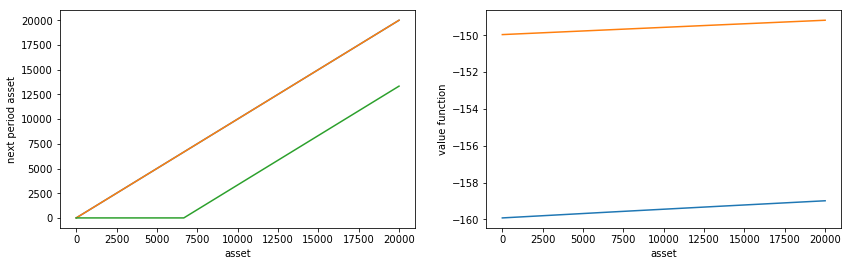

In [50]:
m.show_assets([0,1],0,0)

Hours worked policy (regime index, asset index, shock index):

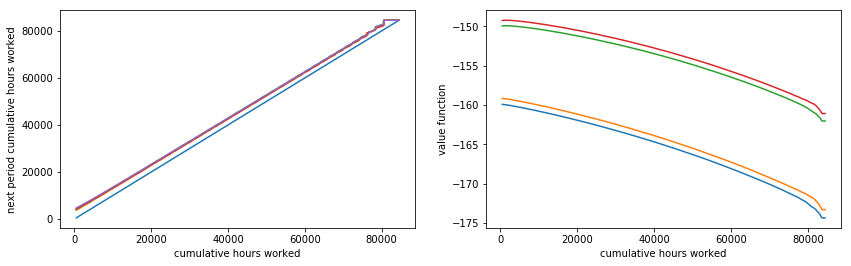

In [51]:
m.show_hours([0,1],0,[0,2])

Simulate one agent:

In [58]:
_tm = pd.read_csv("data/transition_probs.csv", index_col=0).as_matrix()[:,2:]

res_1 = simulate_agent(m, (1, 500, 0, 0))
print_res(res_1)

 Age| Job| PP| Shock | log(h)|     a|    l|     c| log(w) 
  25|   0|  0|    nan|   6.21|     1| 0.00|     0|   0.00
  26|   0|  0|    nan|   6.21|     1| 0.00|     0|   0.00
  27|   0|  0|    nan|   6.21|     1| 0.00|     0|   0.00
  28|   0|  0|    nan|   6.21|     1| 0.00|     0|   0.00
  29|   0|  0|    nan|   6.21|     1| 0.00|     0|   0.00
  30|   0|  0|    nan|   6.21|     1| 0.00|     0|   0.00
  31|   0|  0|    nan|   6.21|     1| 0.00|     0|   0.00
  32|   0|  0|    nan|   6.21|     1| 0.00|     0|   0.00
  33|   0|  0|    nan|   6.21|     1| 0.00|     0|   0.00
  34|   0|  0|    nan|   6.21|     1| 0.00|     0|   0.00
  35|   1|  0|  0.100|   8.33|  6668| 0.65| 33314|  10.94
  36|   1|  0| -0.100|   8.89|  6668| 0.55| 32101|  10.71
  37|   1|  0| -0.100|   9.23|  6668| 0.53| 32044|  10.71
  38|   1|  0|  0.000|   9.52| 13334| 0.62| 31186|  10.88
  39|   0|  0|    nan|   9.52| 13334| 0.00|   533|   0.00
  40|   0|  0|    nan|   9.52| 13334| 0.00|   533|   0.00
  41|   0|  0

Simulate all agents:

In [13]:
(res0, res1) = integrate(m)

Average log earnings and cumulative hours worked versus period:

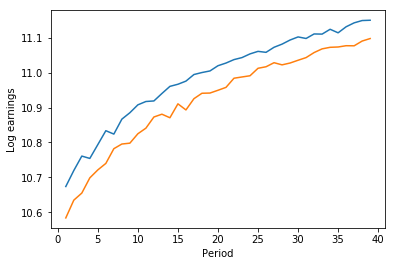

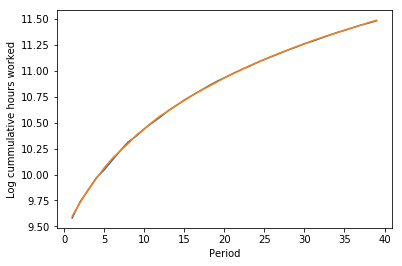

In [14]:
plt.figure()
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res1[1:,6]))
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res0[1:,6]))

plt.xlabel("Period")
plt.ylabel("Log earnings")
plt.figure()
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res1[1:,3]))
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res0[1:,3]))

plt.xlabel("Period")
plt.ylabel("Log cummulative hours worked")
plt.show()

Load model data for Group 2 from existing file

In [15]:
m.load_from_csv(2)

Assets policy (regime index, hours index, shock index):

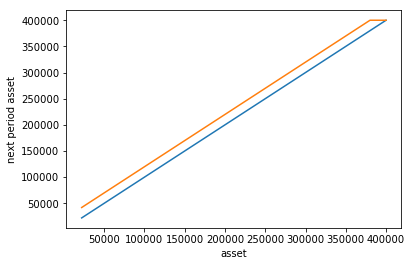

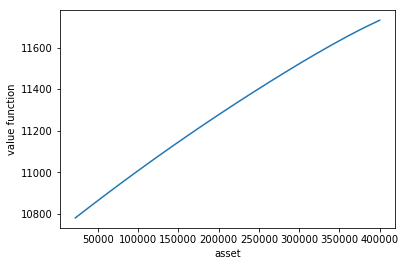

In [16]:
m.show_assets(0,10,1)

Hours worked policy (regime index, asset index, shock index):

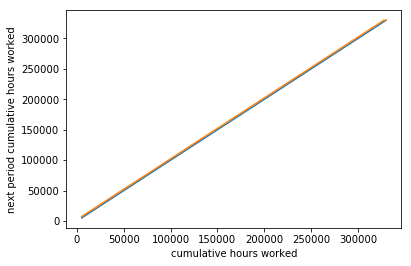

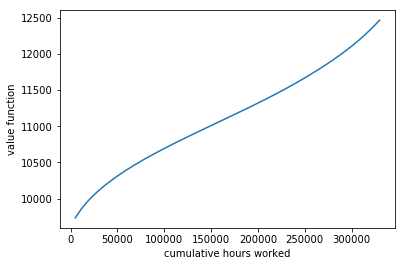

In [17]:
m.show_hours(2,10,1)

Simulate one agent:

In [18]:
res_1 = simulate_agent(m)

 Period| Job| PP| Shock|     h|      a|    l|     c|     w 
      0|   -|  -|     -|  7167| 121474|    -|     -|     -
      1|   0|  1|  0.00|  9333| 141368| 0.5015| 15811| 43446
      2|   1|  0|  0.00| 11500| 161263| 0.5015| 12140| 37155
      3|   0|  0|  0.00| 13667| 181158| 0.5015| 17893| 44137
      4|   6|  0|  0.00| 15833| 201053| 0.5015| 15233| 39269
      5|   3|  1|  0.00| 18000| 220947| 0.5015| 18152| 42260
      6|   1|  1|  0.00| 20167| 240842| 0.5015| 22756| 47624
      7|   0|  0|  0.00| 22333| 260737| 0.5015| 25800| 50791
      8|   0|  1|  0.00| 24500| 280632| 0.5015| 27889| 52612
      9|   0|  0|  0.00| 26667| 300526| 0.5015| 26630| 49718
     10|   4|  0|  0.00| 28833| 320421| 0.5015| 21353| 41164
     11|   0|  1|  0.00| 31000| 340316| 0.5015| 35410| 59841
     12|   5|  0|  0.00| 33167| 360211| 0.5015| 21732| 39456
     13|   3|  1|  0.00| 35333| 380105| 0.5015| 30080| 50094
     14|   0|  1|  0.00| 37500| 400000| 0.5015| 39831| 62706
     15|   0|  1| -0.20| 39

Simulate all agents:

In [19]:
(res0, res1) = integrate(m)

Average log earnings and cumulative hours worked versus period:

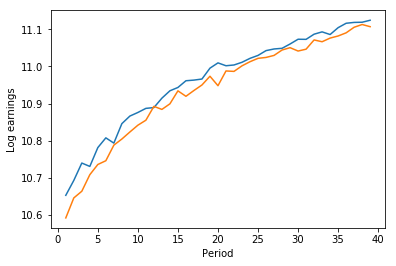

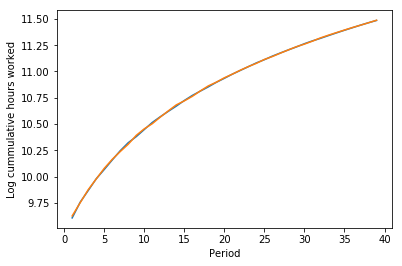

In [20]:
plt.figure()
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res1[1:,6]))
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res0[1:,6]))

plt.xlabel("Period")
plt.ylabel("Log earnings")
plt.figure()
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res1[1:,3]))
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res0[1:,3]))

plt.xlabel("Period")
plt.ylabel("Log cummulative hours worked")
plt.show()

Load model data for Group 3 from existing file

In [21]:
m.load_from_csv(3)

Assets policy (regime index, hours index, shock index):

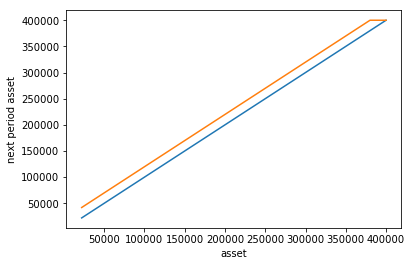

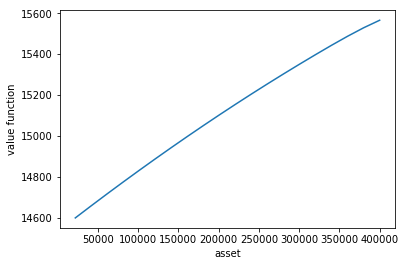

In [22]:
m.show_assets(0,10,1)

Hours worked policy (regime index, asset index, shock index):

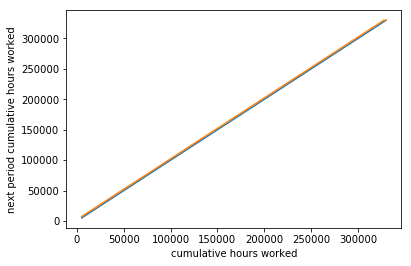

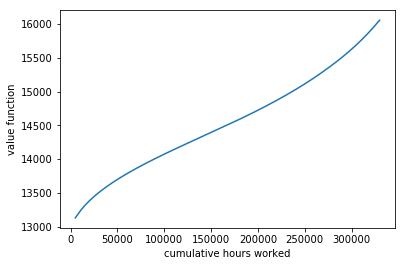

In [23]:
m.show_hours(2,10,1)

Simulate one agent:

In [24]:
res_1 = simulate_agent(m)

 Period| Job| PP| Shock|     h|      a|    l|     c|     w 
      0|   -|  -|     -|  9333| 201053|    -|     -|     -
      1|   0|  1|  0.00| 11500| 220947| 0.5015| 20926| 46167
      2|   3|  1|  0.00| 13667| 240842| 0.5015| 16820| 39263
      3|   0|  1|  0.20| 15833| 260737| 0.5015| 33445| 61558
      4|   0|  0|  0.00| 18000| 280632| 0.5015| 22185| 44578
      5|   0|  1|  0.00| 20167| 300526| 0.5015| 26877| 50066
      6|   0|  0|  0.00| 22333| 320421| 0.5015| 25750| 47357
      7|   0|  1| -0.20| 24500| 320421| 0.5015| 43400| 43075
      8|   1|  1|  0.00| 26667| 340316| 0.5015| 29220| 51123
      9|   1|  1|  0.00| 28833| 360211| 0.5015| 28228| 48605
     10|   1|  1|  0.00| 31000| 380105| 0.5015| 29649| 49486
     11|   1|  1|  0.00| 33167| 400000| 0.5015| 31035| 50318
     12|   6|  0|  0.00| 35333| 400000| 0.5015| 50799| 49013
     13|   4|  1|  0.00| 37500| 400000| 0.5015| 49648| 47392
     14|   1|  1|  0.00| 39667| 400000| 0.5015| 56031| 56382
     15|   6|  1|  0.00| 41

Simulate all agents:

In [25]:
(res0, res1) = integrate(m)

Average log earnings and cumulative hours worked versus period:

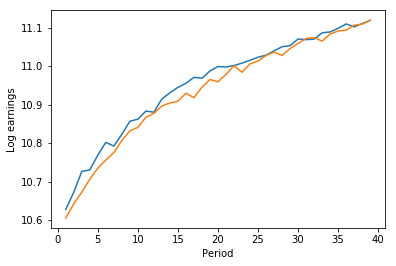

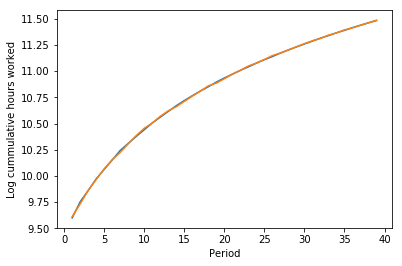

In [26]:
plt.figure()
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res1[1:,6]))
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res0[1:,6]))

plt.xlabel("Period")
plt.ylabel("Log earnings")
plt.figure()
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res1[1:,3]))
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res0[1:,3]))

plt.xlabel("Period")
plt.ylabel("Log cummulative hours worked")
plt.show()